In [1]:
library(keras)

In [2]:
load_img_data <- function(path){
  image.list <-  list.files(path = path, pattern = "*.jpg", full.names = TRUE)
  filenames <- sort(image.list)
  
  X <- array(NA,c(length(filenames),120,160,3))
  Y1 <- array(NA,c(length(filenames)))
  Y2 <- array(NA,c(length(filenames) ))
  ang_arr <-  array(NA,c(length(filenames))) 
  thr_arr <-  array(NA,c(length(filenames))) 
    
  for(i in 1:length(filenames)){
    img_path = filenames[i]
    print(img_path)
    img <- image_load(img_path, target_size = c(120, 160))
    x <- image_to_array(img)/255
    X[i,,,] <- array_reshape(x, dim = c(1, 120, 160, 3))
    
    file.path.parts <- strsplit(filenames[i],'/')[[1]]
    file.parts <- strsplit(file.path.parts[length(file.path.parts)],'_')[[1]]
    throttle <- as.numeric(file.parts[4])
    angle <- as.numeric(file.parts[6])

    Y1[i] <- angle 
      
    if(throttle<0){
        throttle <- 0
    }
    Y2[i] <-  throttle 
      
    thr_arr[i] <- throttle
    ang_arr[i] <- angle  
    
  }
  list(x=X,y1=Y1,y2=Y2,n=length(filenames), angle = ang_arr, throttle=thr_arr, filenames = filenames)
}




In [3]:
sampling_generator <- function(img.data, sample_set, batch_size) {
  function() {
    rows <- sample(sample_set, batch_size, replace = TRUE)
    list(img.data$x[rows,,,], list(img.data$y1[rows], img.data$y2[rows] ))
  }
}

In [74]:
model_file_name <- "~/rccar_satrday.hdf5"

path <- "/home/heuniss/project-data/rccars/sessions/philip_sessions/fri/"
#path  <- "/home/heuniss/project-data/rccars/sessions/home/philip/donkey/schalk_sessions_backup_on_aws/sessions/record_00077"


library(R.cache)
setCacheRootPath("/home/heuniss/project-data/rccars/cache")
img.data <- loadCache(key=list(path=path))
if(is.null(img.data) ){
  img.data <- load_img_data(path)
  saveCache(img.data, key=list(path=path))
}


In [75]:
set.seed(101) # Set Seed so that same sample can be reproduced in future also
sample <- sample.int(n = img.data$n, size = floor(.75*img.data$n), replace = FALSE)
train.list <- sample
test.list  <- seq(1,img.data$n)[-sample]


In [76]:
inputs <- layer_input(c(120, 160, 3))

convlayers <- inputs %>%
  
  # Start with hidden 2D convolutional layer being fed 32x32 pixel images
  layer_conv_2d(
    filter = 24, kernel_size = c(5,5),  strides = c(2,2), activation = "relu"
  ) %>%
  layer_conv_2d(
    filter = 32, kernel_size = c(5,5),  strides = c(2,2) , activation = "relu"
  ) %>%
  layer_conv_2d(
    filter = 64, kernel_size = c(5,5),  strides = c(2,2), activation = "relu"
  ) %>%
  layer_conv_2d(
    filter = 64, kernel_size = c(3,3),  strides = c(2,2), activation = "relu"
  ) %>%
  layer_conv_2d(
    filter = 64, kernel_size = c(3,3), padding = "valid", strides = c(1,1), activation = "relu"
  ) 
 
predictions <- convlayers %>% 
  
  # Flatten max filtered output into feature vector 
  # and feed into dense layer
  layer_flatten(name="embedding") %>%
  
  layer_dense(100) %>%
  layer_activation("relu") %>%
  layer_dropout(0.1) %>%
 
  layer_dense(50) %>%
  layer_activation("relu") %>%
  layer_dropout(0.1) 

angle <- predictions %>% 
  layer_dense(1, name="angle") 

throttle <- predictions %>% 
  layer_dense(1, name="throttle") 

model <- keras_model(inputs = inputs, outputs = c(angle, throttle))
model %>% compile(
  optimizer = 'adam',
  loss = 'mean_absolute_error',
  metrics = list('mae')
)

summary(model)

________________________________________________________________________________
Layer (type)              Output Shape      Param #  Connected to               
input_3 (InputLayer)      (None, 120, 160,  0                                   
________________________________________________________________________________
conv2d_11 (Conv2D)        (None, 58, 78, 24 1824     input_3[0][0]              
________________________________________________________________________________
conv2d_12 (Conv2D)        (None, 27, 37, 32 19232    conv2d_11[0][0]            
________________________________________________________________________________
conv2d_13 (Conv2D)        (None, 12, 17, 64 51264    conv2d_12[0][0]            
________________________________________________________________________________
conv2d_14 (Conv2D)        (None, 5, 8, 64)  36928    conv2d_13[0][0]            
________________________________________________________________________________
conv2d_15 (Conv2D)        (N

In [77]:
if(!file.exists(model_file_name)){
    bs = 256
    history <- model %>% 
      fit_generator(generator = sampling_generator(img.data, train.list, batch_size = bs), 
                    steps_per_epoch = round(length(train.list) / bs), epochs = 20,
                    validation_data = sampling_generator(img.data, test.list, batch_size = bs),
                    validation_steps = round(length(test.list) / bs))
    save_model_hdf5(model,filepath = model_file_name)
    save(history, file = paste(model_file_name,".history",sep=""))
} else {
    model <- load_model_hdf5(filepath = model_file_name)
    load(paste(model_file_name,".history",sep=""))
}

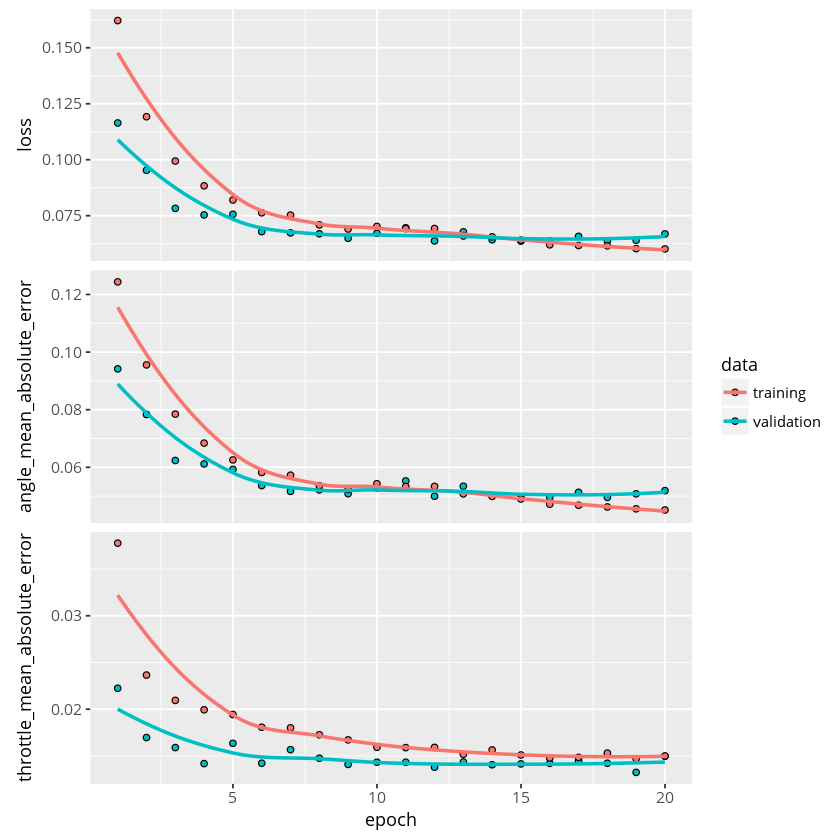

In [78]:
plot(history, metrics=c("loss","angle_mean_absolute_error","throttle_mean_absolute_error"))

In [79]:
predicted <- model %>% predict(img.data$x[,,,])

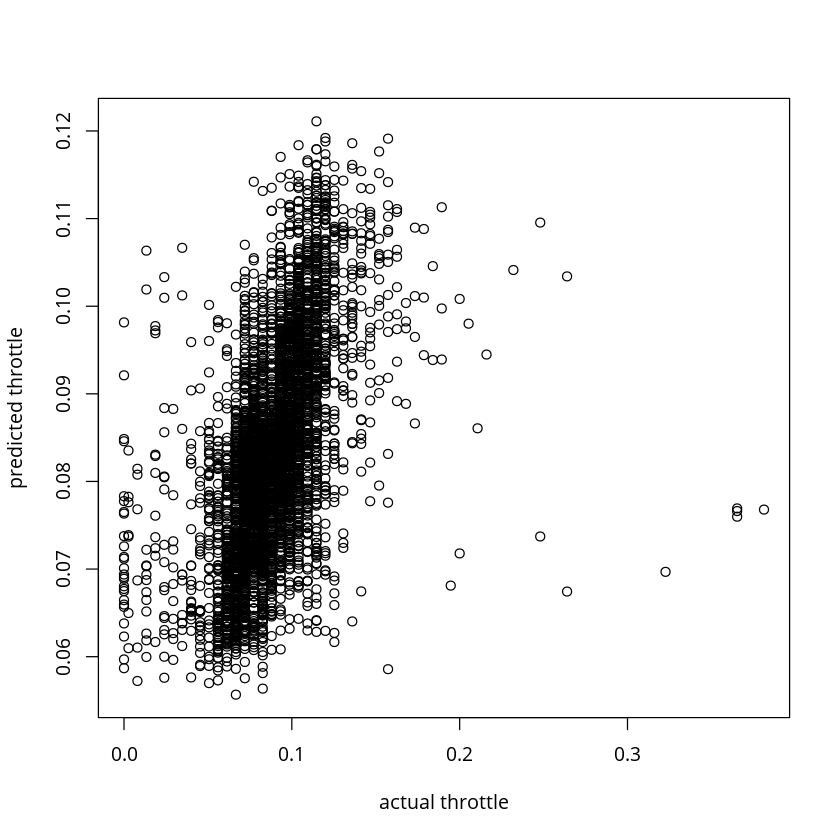

In [80]:
plot(img.data$throttle, predicted[[2]], xlab = "actual throttle",ylab="predicted throttle")

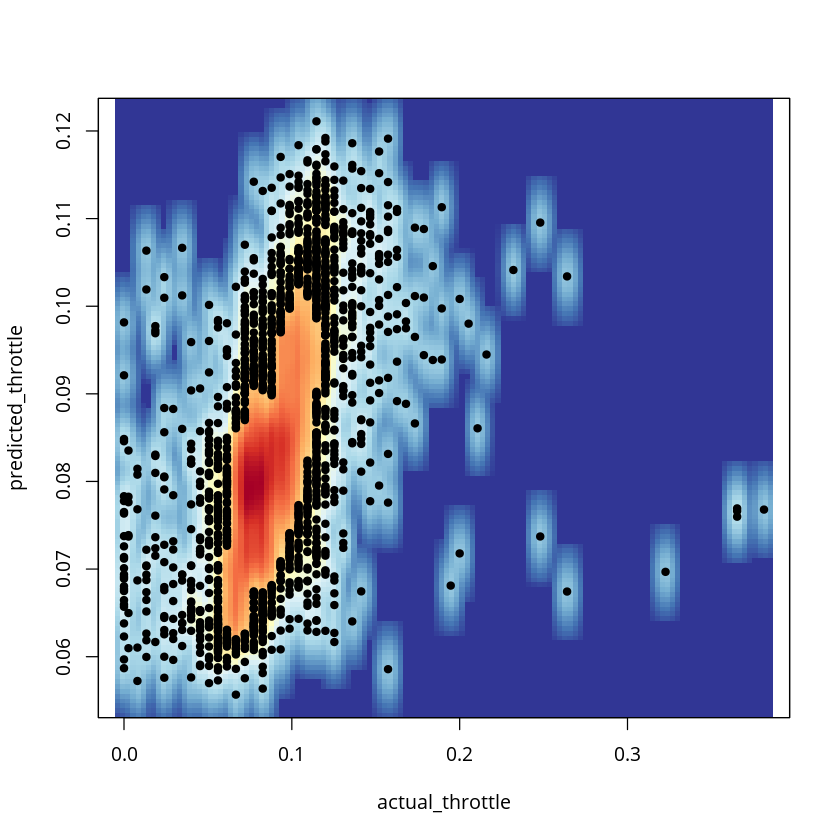

In [81]:
df <- data.frame(actual_throttle=img.data$throttle, predicted_throttle=predicted[[2]])
n <- nrow(df)
library(RColorBrewer)
k <- 11
my.cols <- rev(brewer.pal(k, "RdYlBu"))
smoothScatter(df, nrpoints=.3*n, colramp=colorRampPalette(my.cols), pch=19, cex=.8)

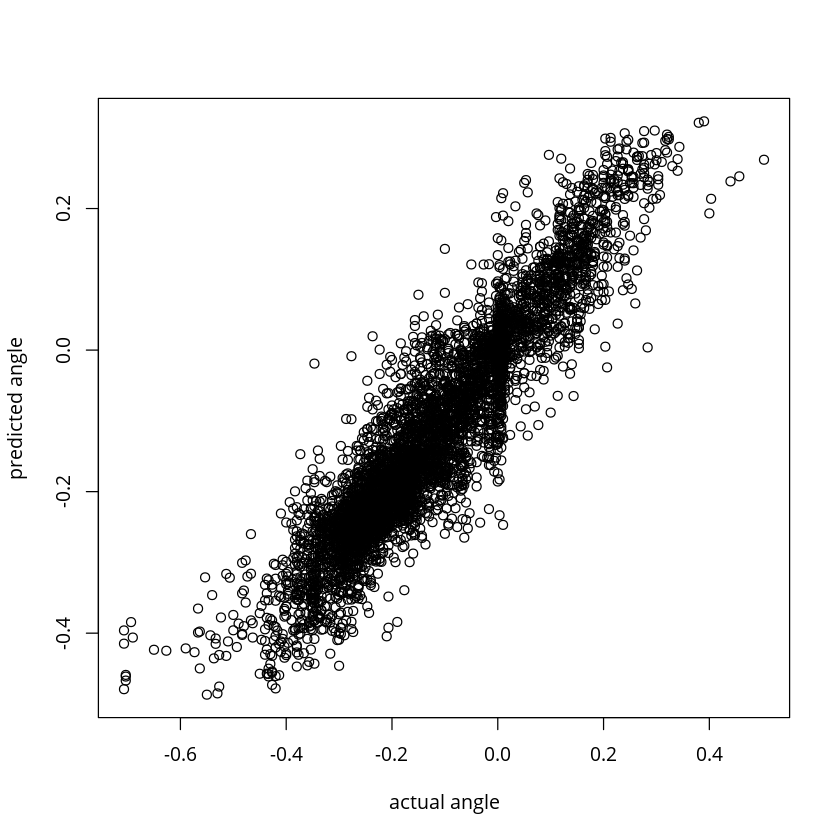

In [82]:
plot(img.data$angle, predicted[[1]], xlab = "actual angle",ylab="predicted angle")

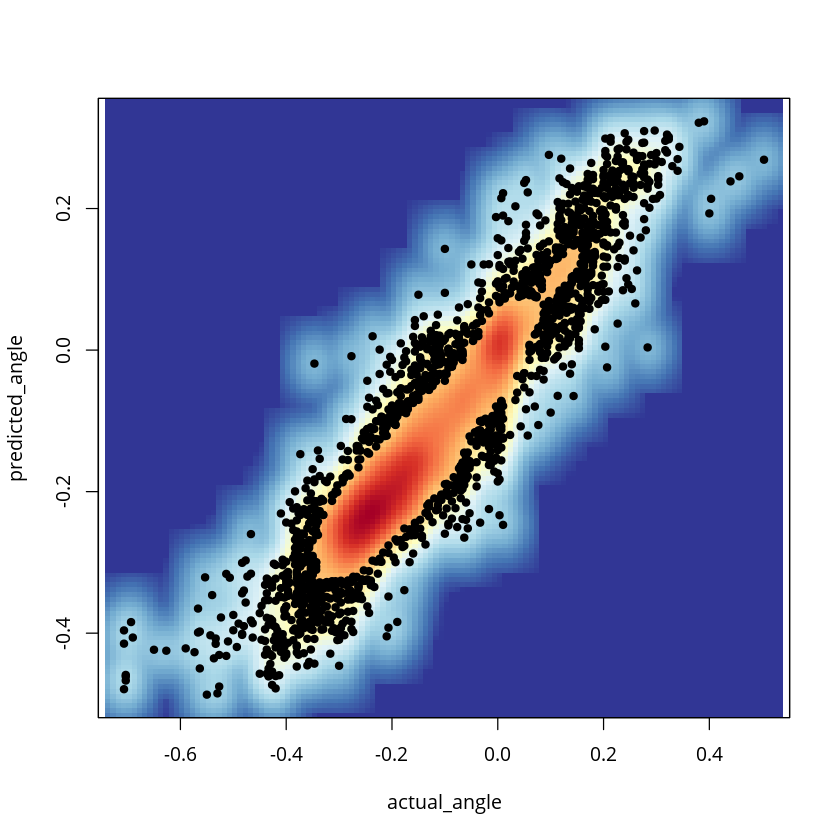

In [83]:
df <- data.frame(actual_angle=img.data$angle, predicted_angle=predicted[[1]])
n <- nrow(df)
library(RColorBrewer)
k <- 11
my.cols <- rev(brewer.pal(k, "RdYlBu"))
smoothScatter(df, nrpoints=.3*n, colramp=colorRampPalette(my.cols), pch=19, cex=.8)

In [84]:
layer_name <- 'embedding'
intermediate_layer_model <- keras_model(inputs = model$input,
                                        outputs = get_layer(model, layer_name)$output)
intermediate_output <- predict(intermediate_layer_model, img.data$x)



In [85]:
library(parallelDist)
d <- parDist(intermediate_output)
h <- hclust(d, method="ward.D")


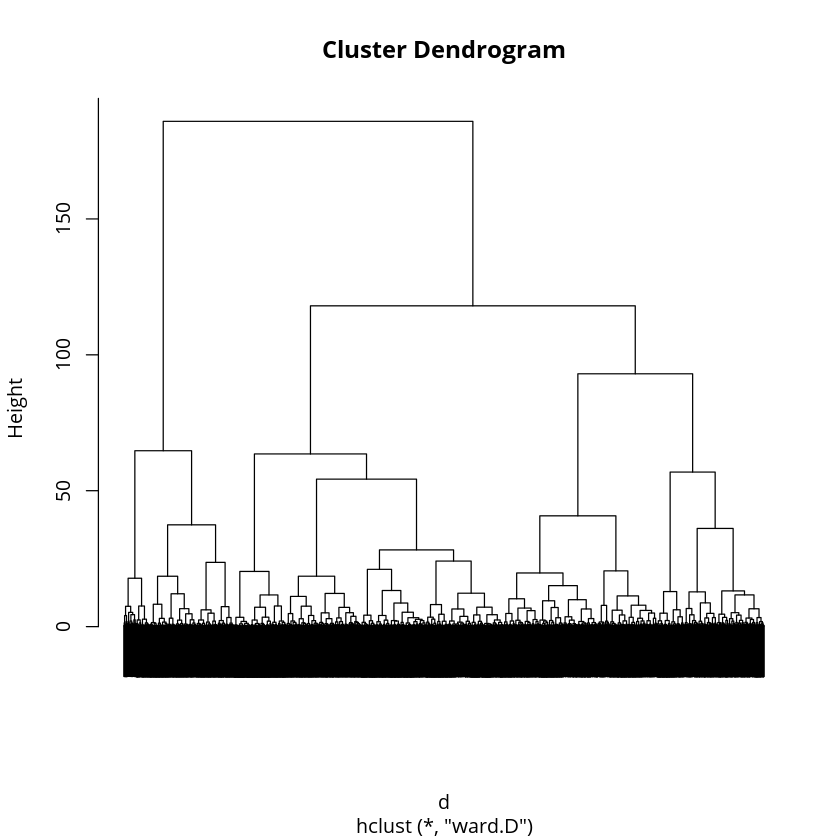

In [86]:
plot(h, labels=FALSE)

In [87]:
h.cut <- cutree(h, 4)

In [127]:
plot_jpeg = function(path, add=FALSE,xi,yi,h,w, rows, cols, color=NULL, angle=NULL, throttle=NULL, draw.raster=TRUE, lwd=2)
{
  require('jpeg')
  jpg = readJPEG(path, native=T) # read the file
  res = dim(jpg)[2:1] # get the resolution, [x, y]
  width = w * cols
  height  = h * rows  
  x = (xi - 1) * w
  y = (yi - 1) * h  
  if (!add) # initialize an empty plot area if add==FALSE
    plot(0,0,xlim=c(0,width),ylim=c(0,height),asp=1,type='n',xaxs='i',yaxs='i',xaxt='n',yaxt='n',xlab='',ylab='',bty='n')
  
  if(draw.raster){  
      rasterImage(jpg,x,y,x+w,y+h)
  }
  if(!is.null(color)){  
      rect(x,y,x+w,y+h,col=color, border = NA)
  }
  if(!is.null(angle)){
      y1 = y+h*cos(angle*pi/2)
      x1 = x+w/2+w*sin(angle*pi/2)
      
      arrows(x+w/2, y, x1=x1,y1=y1, length=throttle, col="red", lwd=lwd)
  }
}

Mode <- function(x) {
  ux <- unique(x)
  ux[which.max(tabulate(match(x, ux)))]
}

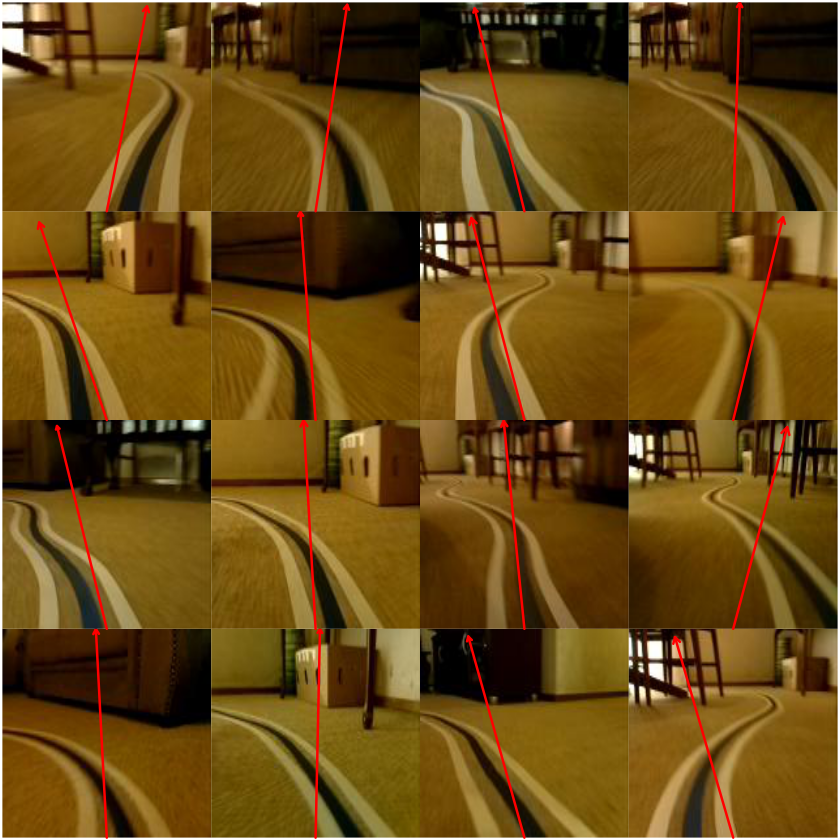

In [89]:
par(mfrow=c(1,1))
op <- par(mar = rep(0.1, 4))
for(cluster in c(2)){
    N = 4
    smpl <- sample(which(h.cut==cluster),N*N, replace=TRUE)
    smpl <- sort(smpl)
    for(i in 1:N){
        for(j in 1:N){
            new <- i==1 && j==1
            index <- (j-1)*N+i
            if(index> length(smpl)){
                index <- length(smpl)
            }
            plot_jpeg(img.data$filenames[smpl[index]],add = !new, i,j, 12, 12,N,N, angle=img.data$angle[smpl[index]], throttle=img.data$throttle[smpl[index]]*0.5, draw.raster=TRUE )
            #plot_jpeg(img.data$filenames[smpl[index]],add = !new, i,j, 12, 12,N,N, angle=predicted[[1]][smpl[index]], throttle=predicted[[2]][smpl[index]]*0.5, draw.raster=TRUE )

        }
    }
}
par(op)

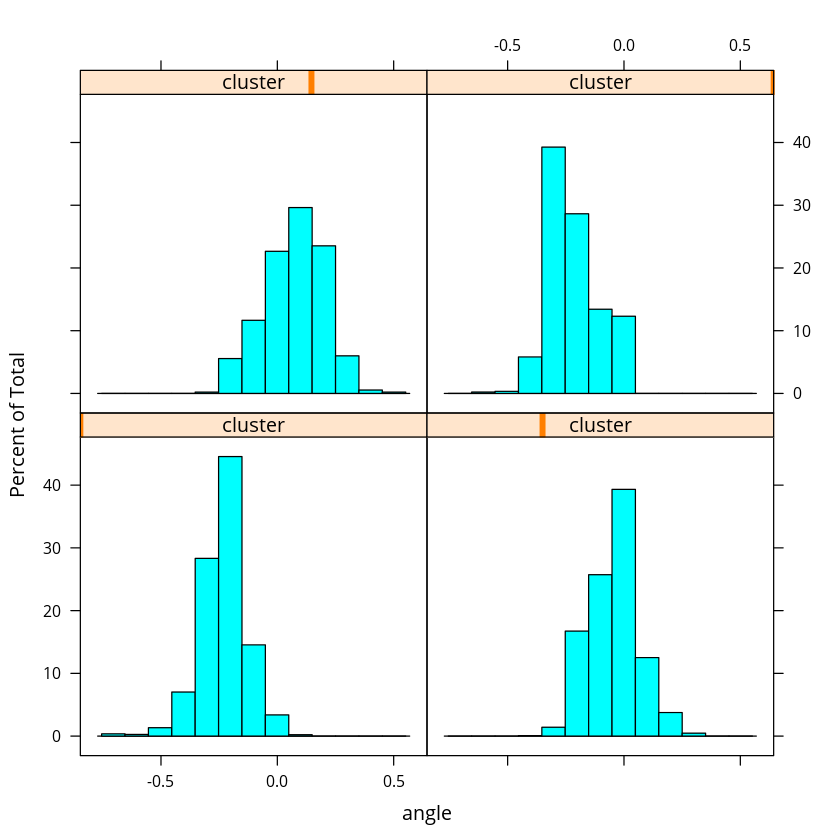

In [94]:

library(lattice)
df <- data.frame(angle=img.data$angle, angle_err=as.double(img.data$angle) - predicted[[1]],ang_pred=predicted[[1]], cluster=h.cut)
histogram(~angle|cluster,df, layout=c(2,2))



In [95]:
library(Rtsne)

In [96]:
ts <- Rtsne(d, perplexity = 50)

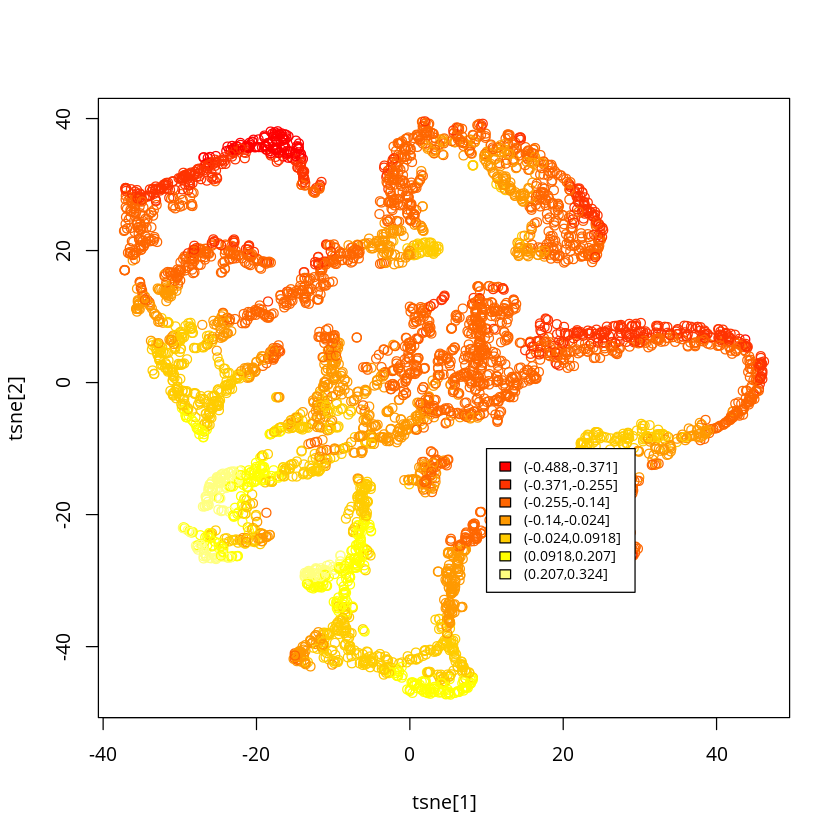

In [97]:
plot(ts$Y,col=heat.colors(7)[cut(predicted[[1]],7)], xlab="tsne[1]", ylab="tsne[2]")
legend(10,-10,legend = levels(cut(predicted[[1]],7)), fill = heat.colors(7), cex=0.7)

In [98]:
library(dplyr)

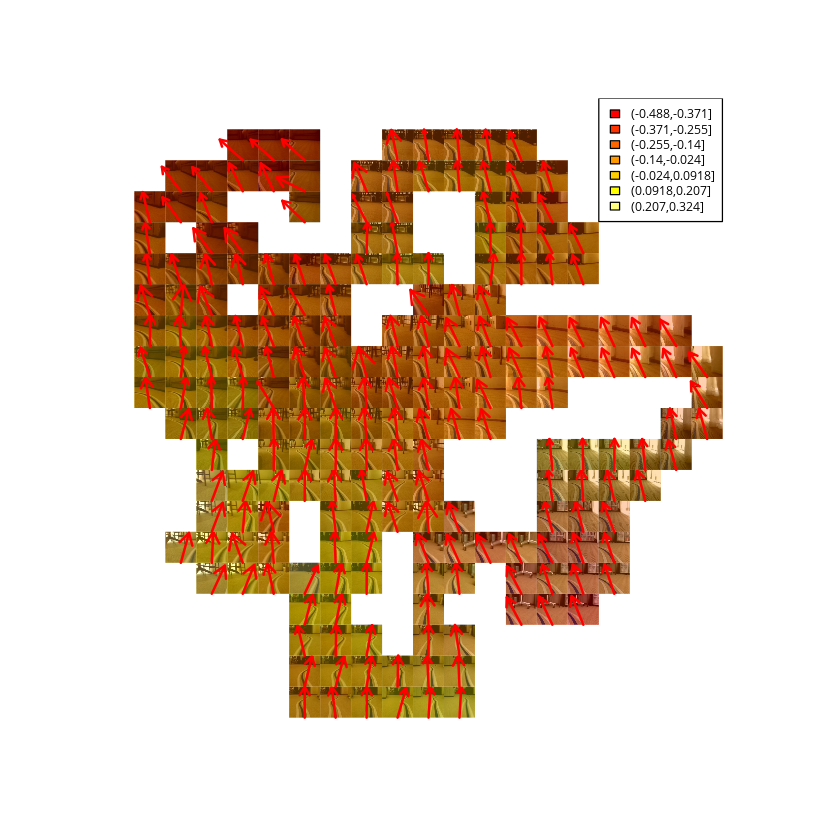

In [99]:
grid.size <- 20
ts.df <- data.frame(x=ts$Y[,1],y=ts$Y[,2], filename=img.data$filenames, class=cut(predicted[[1]],7), throttle=img.data$throttle, angle=img.data$angle)
ts.df$xclass <- cut(ts.df$x,breaks = seq(min(ts.df$x), max(ts.df$x), length.out = grid.size), labels=FALSE)
ts.df$yclass <- cut(ts.df$y,breaks = seq(min(ts.df$y), max(ts.df$y), length.out = grid.size),labels=FALSE)

selected <-
    ts.df %>% group_by(xclass,yclass) %>%
      summarize(fn=filename[1],colclass = Mode(class), throttle=throttle[1], angle=angle[1] ) %>%
      select(xclass,yclass, fn, colclass, throttle, angle)

N <- grid.size
for(i in 1:nrow(selected)){
    fp <- as.character(selected$fn[i])
    plot_jpeg(fp,add = i>1, selected$xclass[i],selected$yclass[i], 50, 50,N,N, heat.colors(7,alpha=0.3)[selected$colclass[i]], selected$angle[i], selected$throttle[i], draw.raster=TRUE )
}

legend(15*50,20*50,legend = levels(cut(predicted[[1]],7)), fill = heat.colors(7), cex = 0.6)

In [100]:
pr.result <- prcomp(intermediate_output)

In [103]:
?autoplot


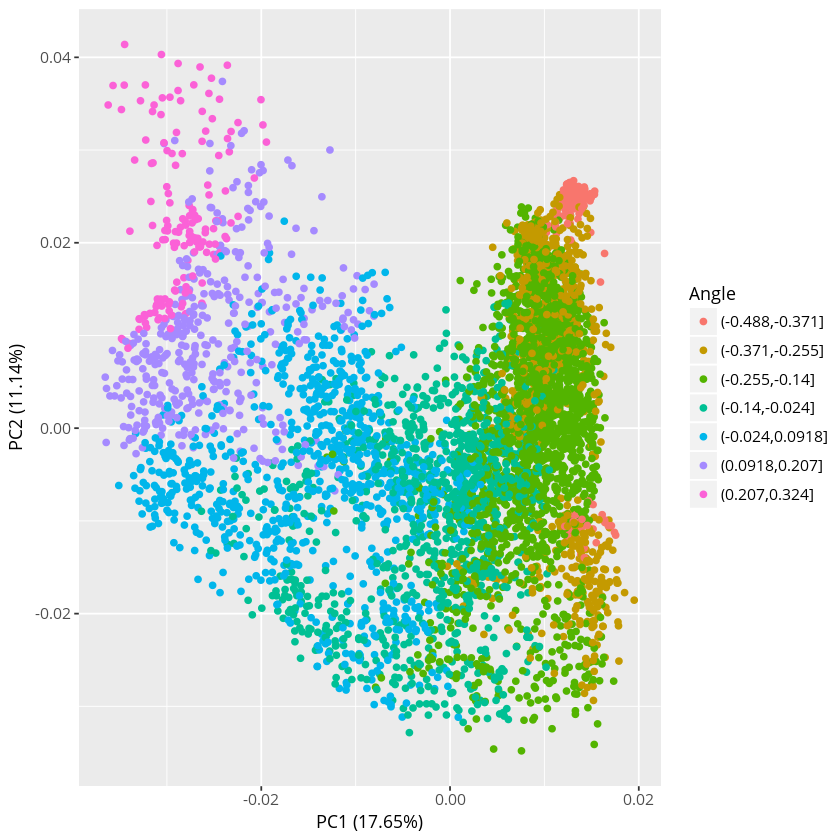

In [108]:
library(ggfortify)
ts.df$Angle <- as.factor(ts.df$class)
autoplot(pr.result, data = ts.df, colour = 'Angle')

In [146]:
grid.size <- 20

gg_color_hue <- function(n) {
  hues = seq(15, 375, length = n + 1)
  hcl(h = hues, l = 65, c = 100, alpha=0.25)[1:n]
}

pc1 <- pr.result$x[,1]
pc2 <- pr.result$x[,2]

pr.df <- data.frame(x=pc1,y=pc2, filename=img.data$filenames, class=cut(predicted[[1]],7), angle=img.data$angle, throttle=img.data$throttle)
pr.df$xclass <- cut(pr.df$x,breaks = seq(min(pr.df$x), max(pr.df$x), length.out = grid.size), labels=FALSE)
pr.df$yclass <- cut(pr.df$y,breaks = seq(min(pr.df$y), max(pr.df$y), length.out = grid.size),labels=FALSE)

selected.pr <-
pr.df %>% group_by(xclass,yclass) %>%
  sample_n(size = 1) %>%
  summarize(fn=filename[1],colclass = Mode(class), angle=angle[1], throttle=throttle[1] ) %>%
  select(xclass,yclass, fn, colclass, angle, throttle)

png("~/project-data/rccars/pca_photos_arrows.png",1024*3,768*3)
N <- grid.size
for(i in 1:nrow(selected.pr)){
    fp <- as.character(selected.pr$fn[i])
    plot_jpeg(fp,add = i>1, selected.pr$xclass[i],selected.pr$yclass[i], 50, 50,N,N, gg_color_hue(7)[as.numeric(selected.pr$colclass[i])], selected.pr$angle[i], selected.pr$throttle[i]*3, draw.raster=TRUE, lwd=6 )
}
dev.off()
#legend(0*grid.size*50,1*grid.size*50,legend = levels(cut(predicted[[1]],7)), fill = heat.colors(7), cex = 0.6)

png 
  2

<img src="pca_photos_arrows.png"/>

In [138]:
gg_color_hue(7)

[1] "#F8766D80" "#C49A0080" "#53B40080" "#00C09480" "#00B6EB80" "#A58AFF80"
[7] "#FB61D780"

In [140]:
as.numeric(selected.pr$colclass)

[1] 5 6 6 6 7 7 7 7 5 5 5 6 6 7 7 7 7 7 7 7 5 5 5 6 6 6 7 7 7 7 7 7 7 7 5 5 5
 [38] 5 5 6 6 6 6 7 6 7 7 7 7 5 5 5 4 6 5 6 5 6 6 6 7 7 7 7 4 5 5 4 5 6 5 5 6 6
 [75] 6 6 6 7 7 4 5 4 5 5 4 5 5 5 5 6 6 5 6 5 4 4 5 5 4 5 5 5 6 6 6 6 4 5 4 4 5
[112] 5 5 5 5 5 6 6 6 4 4 5 4 5 5 5 5 5 5 5 6 4 5 5 5 4 4 5 5 4 4 4 5 5 4 5 4 5
[149] 3 4 4 4 3 4 4 5 4 4 4 3 4 5 5 4 4 3 4 3 3 4 3 3 4 4 3 5 4 4 3 4 3 2 4 4 4
[186] 3 4 4 4 3 3 3 4 3 3 2 3 3 3 3 3 3 2 3 4 3 3 3 2 3 3 3 2 3 3 3 3 2 3 2 3 3
[223] 3 2 3 2 3 2 1 3 2 2 2 2 2 3 3 3 3 2 2 2 2 1 1 3 2 2 2 2 1 2 6